# LSTM을 활용한 전려소요 예측 모델

- TensorFlow Dataset 클래스를 활용하여 전력소요 데이터 구축
- LSTM 을 활용한 전력소요 예측 모델 구축

## 필요한 모듈 import

In [1]:
from matplotlib import font_manager, rc
import matplotlib, os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import platform
import tensorflow as tf

if platform.system() == 'Windows':
# 윈도우인 경우 맑은 고딕 폰트 이용
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf"
                                           ).get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

#그래프에서 마이너스 기호가 표시되게 하는 설정입니다.
plt.rcParams['axes.unicode_minus'] == False

False

## 데이터 (FinanceDataReader)

In [2]:
# 시간별_전력데이터 전체 (2012-06-01 ~ 2022-04-07)
path = 'processing_data/시간별_전력데이터.csv'
df = pd.read_csv(path, encoding='cp949')

### 컬럼 설명

- `공급능력`:   전력생산량
- `현재수요`:   그날 사용한 전력량
- `공급예비력`:   전력 생산하고 남은 양
- `전력예비율`:  전력예비율 = (총 공급 전력량-최대 전력수요 / 최대 전력 수요) × 100
전력예비율이 6% 이하로 떨어지면 블랙아웃 가능성이 높아졌다는 뜻


In [3]:
df.tail()

,Unnamed: 0,공급능력(MW),현재수요(MW),공급예비력(MW),공급예비율(퍼센트),datetime
86333,86333,83646.116667,69966.391667,13679.708333,19.555125,2022-04-07 19:00:00
86334,86334,83715.825000,68310.458333,15405.366667,22.558508,2022-04-07 20:00:00
86335,86335,83529.483333,66472.925000,17056.575000,25.663192,2022-04-07 21:00:00
86336,86336,83061.116667,65215.066667,17846.050000,27.372808,2022-04-07 22:00:00
86337,86337,82854.066667,64148.233333,18705.825000,29.185117,2022-04-07 23:00:00


## 시각화

In [4]:
# plt.figure(figsize=(16, 9))
# sns.lineplot(y=df['현재수요(MW)'], x=df['datetime'])
# plt.xlabel('time')
# plt.ylabel('price')
# plt.grid(True)
# plt.show()

In [5]:
df.drop( labels=['Unnamed: 0'],inplace =True,axis=1)

In [6]:
df

,공급능력(MW),현재수요(MW),공급예비력(MW),공급예비율(퍼센트),datetime
0,64355.000000,50990.289167,13364.711667,26.224017,2012-06-01 00:00:00
1,64355.000000,50064.355000,14290.646667,28.545997,2012-06-01 01:00:00
2,64559.166667,49986.542500,14572.623333,29.156328,2012-06-01 02:00:00
3,64845.000000,50093.080833,14751.918333,29.453125,2012-06-01 03:00:00
4,64845.000000,50456.725833,14388.274167,28.518804,2012-06-01 04:00:00
...,...,...,...,...,...
86333,83646.116667,69966.391667,13679.708333,19.555125,2022-04-07 19:00:00
86334,83715.825000,68310.458333,15405.366667,22.558508,2022-04-07 20:00:00
86335,83529.483333,66472.925000,17056.575000,25.663192,2022-04-07 21:00:00
86336,83061.116667,65215.066667,17846.050000,27.372808,2022-04-07 22:00:00


In [7]:
df = df.set_index('datetime')

In [8]:
time_steps = [['2013', '2014'], 
              ['2014', '2015'], 
              ['2015', '2016'],
              ['2016', '2017'], 
              ['2017', '2018'], 
              ['2018', '2019'], 
              ['2019', '2020'], 
              ['2020', '2021']]

In [9]:
df.loc[(df.index > time_steps[0][0]) & (df.index < time_steps[0][1])]

,공급능력(MW),현재수요(MW),공급예비력(MW),공급예비율(퍼센트)
datetime,,,,
2013-01-01 00:00:00,77740.000000,60326.235833,17413.763333,28.881679
2013-01-01 01:00:00,77740.000000,57977.469167,19762.529167,34.102047
2013-01-01 02:00:00,77589.333333,56238.060000,21351.272500,37.975934
2013-01-01 03:00:00,76836.000000,55187.587500,21648.411667,39.228697
2013-01-01 04:00:00,76836.000000,54461.064167,22374.935000,41.085581
...,...,...,...,...
2013-12-31 19:00:00,81276.000000,58535.283333,22740.716667,38.858042
2013-12-31 20:00:00,81276.000000,57674.380833,23601.619167,40.923327
2013-12-31 21:00:00,81276.000000,57299.698333,23976.301667,41.848352


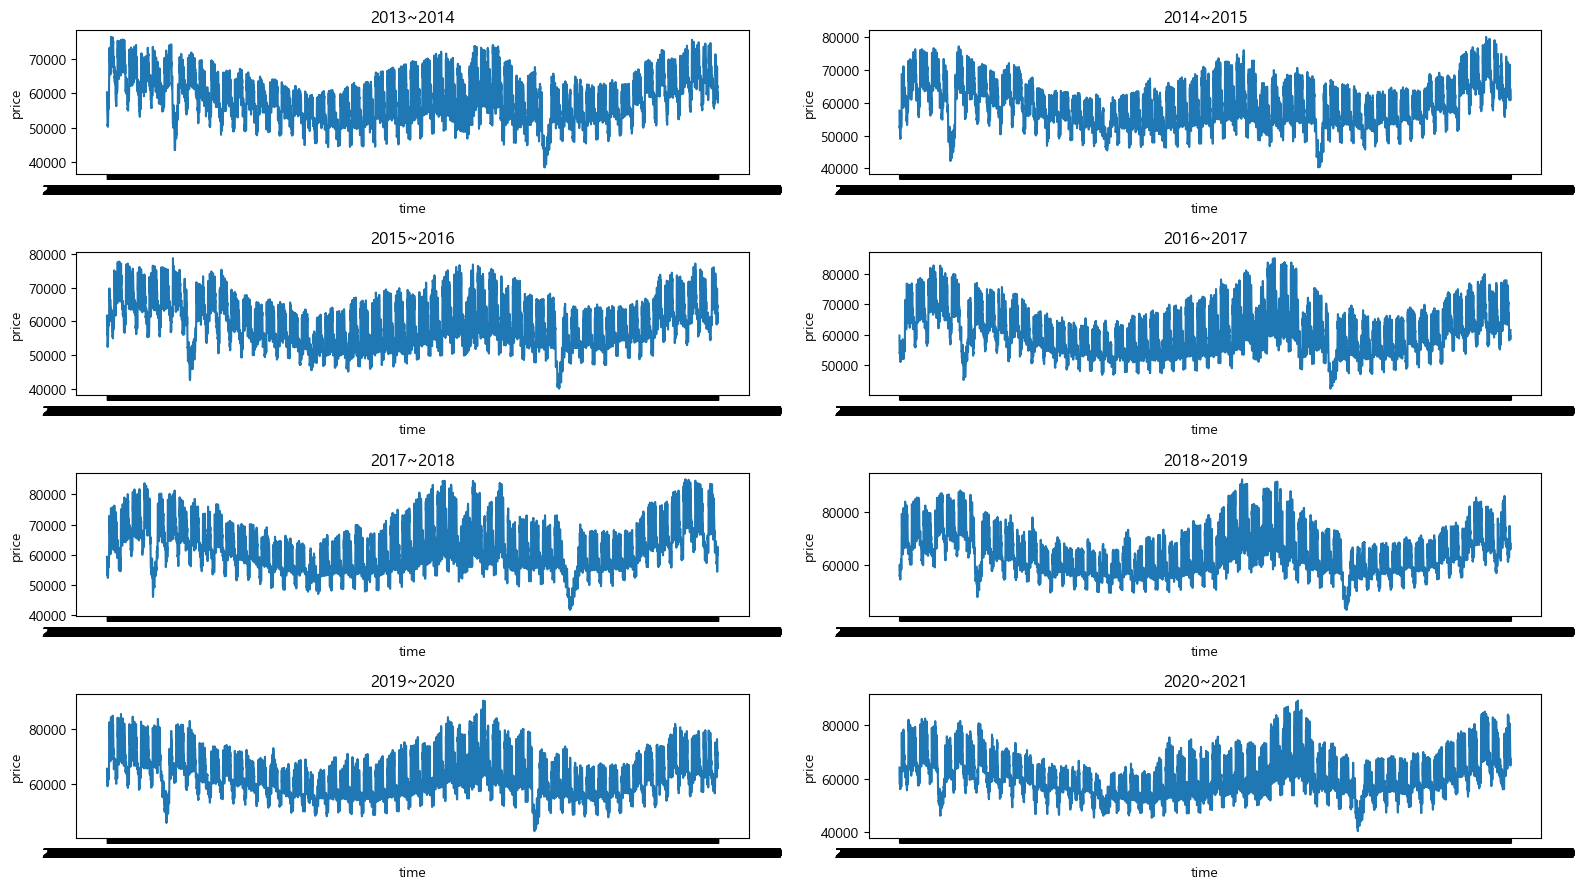

In [10]:
time_steps = [['2013', '2014'], 
              ['2014', '2015'], 
              ['2015', '2016'],
              ['2016', '2017'], 
              ['2017', '2018'], 
              ['2018', '2019'], 
              ['2019', '2020'], 
              ['2020', '2021']]

fig, axes = plt.subplots(4, 2)
fig.set_size_inches(16, 9)
for i in range(8):
    ax = axes[i//2, i%2]
    df_1 = df.loc[(df.index > time_steps[i][0]) & (df.index < time_steps[i][1])]
    sns.lineplot(y=df_1['현재수요(MW)'], x=df_1.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

전력소요 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['공급능력(MW)', '현재수요(MW)', '공급예비력(MW)', '공급예비율(퍼센트)']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])
scaled

array([[0.04961463, 0.25421718, 0.18589205, 0.18998456],
       [0.04961463, 0.23753134, 0.20214105, 0.20959629],
       [0.05314289, 0.23612912, 0.20708938, 0.21475122],
       ...,
       [0.38097472, 0.53322265, 0.25067962, 0.18524776],
       [0.37288074, 0.51055536, 0.26453392, 0.19968739],
       [0.36930264, 0.49133045, 0.27962189, 0.21499437]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [12]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [13]:
df.shape

(86338, 4)

## train / test 분할

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# 1년치 0.423
x_train, x_test, y_train, y_test = train_test_split(df.drop('현재수요(MW)', 1), df['현재수요(MW)'], test_size=0.2, random_state=0, shuffle=False)

C:\Users\ban05\AppData\Local\Temp\ipykernel_13392\846775735.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('현재수요(MW)', 1), df['현재수요(MW)'], test_size=0.2, random_state=0, shuffle=False)


In [16]:
path = 'train,test_data/test_x.csv'
test_x = pd.read_csv(path, encoding='cp949')
path = 'train,test_data/train_x.csv'
train_x = pd.read_csv(path, encoding='cp949')
path = 'train,test_data/test_y.csv'
test_y = pd.read_csv(path, encoding='cp949')
path = 'train,test_data/train_y.csv'
train_y = pd.read_csv(path, encoding='cp949')


In [17]:
test_x.drop(columns=['Unnamed: 0','index'], inplace= True)
train_x.drop(columns=['Unnamed: 0','index'], inplace= True)
test_y.drop(columns=['Unnamed: 0','index'], inplace= True)
train_y.drop(columns=['Unnamed: 0','index'], inplace= True)

In [22]:
test_x.head(2)

,공급능력(MW),1년전 수요(MW),공급예비력(MW),공급예비율(퍼센트),일시,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%)
0,98027.57500,66577.35833,31474.250,47.275842,2020-12-31 01:00:00,서울,-12.6,0.0,1.9,50.0
1,98060.99167,66289.10833,31803.825,47.978425,2020-12-31 02:00:00,서울,-12.6,0.0,3.2,50.0


In [19]:
train_x.shape, train_y.shape

((75212, 10), (75212, 1))

In [21]:
train_x.head(2)

,공급능력(MW),1년전 수요(MW),공급예비력(MW),공급예비율(퍼센트),일시,지점명,기온(°C),강수량(mm),풍속(m/s),습도(%)
0,66967.00,48287.08417,18679.91583,38.688845,2013-06-01 01:00:00,서울,19.6,0.0,1.2,49.0
1,66595.75,48145.44833,18450.30167,38.321357,2013-06-01 02:00:00,서울,18.8,0.0,0.4,51.0


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

---



In [19]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [20]:
WINDOW_SIZE=365
BATCH_SIZE=32

In [21]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [22]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 365, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [24]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [25]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [26]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
   2148/Unknown - 131s 60ms/step - loss: 0.0017 - mse: 0.0034
Epoch 1: val_loss improved from inf to 0.00046, saving model to tmp\ckeckpointer.ckpt
2148/2148 [==============================] - 142s 65ms/step - loss: 0.0017 - mse: 0.0034 - val_loss: 4.6240e-04 - val_mse: 9.2479e-04
Epoch 2/50
2148/2148 [==============================] - ETA: 0s - loss: 3.3258e-04 - mse: 6.6516e-04
Epoch 2: val_loss improved from 0.00046 to 0.00041, saving model to tmp\ckeckpointer.ckpt
2148/2148 [==============================] - 138s 64ms/step - loss: 3.3258e-04 - mse: 6.6516e-04 - val_loss: 4.1171e-04 - val_mse: 8.2342e-04
Epoch 3/50
2148/2148 [==============================] - ETA: 0s - loss: 2.7773e-04 - mse: 5.5545e-04
Epoch 3: val_loss improved from 0.00041 to 0.00038, saving model to tmp\ckeckpointer.ckpt
2148/2148 [==============================] - 133s 62ms/step - loss: 2.7773e-04 - mse: 5.5545e-04 - val_loss: 3.7771e-04 - val_mse: 7.5541e-04
Epoch 4/50
2148/2148 [===================

저장한 ModelCheckpoint 를 로드합니다.

In [ ]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [ ]:
pred = model.predict(test_data)

539/539 [==============================] - 1s 2ms/step


In [ ]:
pred.shape

(17248, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

In [ ]:
type(y_test)

pandas.core.series.Series

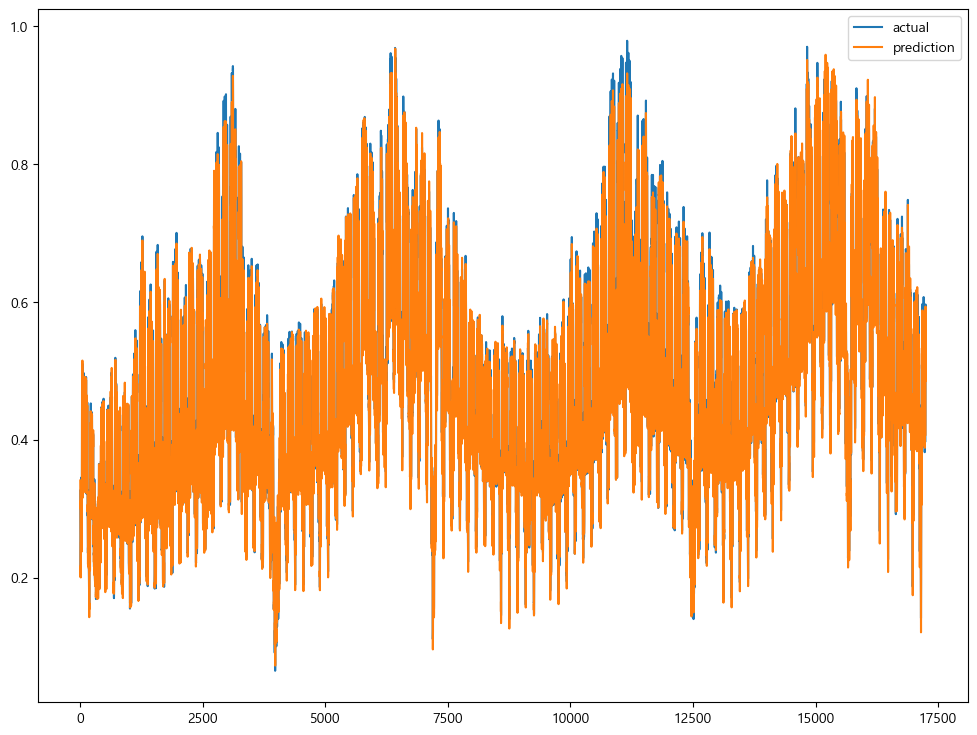

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[365:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()